In [1]:
%%javascript
// to avoid scroll in windows
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
import csv
import os
import sys
import matplotlib.pyplot as plt #also used to generate the legends
from typing import List
import pickle

myListDir=os.listdir()
#folder=input("The name of your input folder without extension: ")
folder=sys.argv[1]
while not folder+".0" in myListDir: #extension 0 certainly exists, as we have at least one rank
    print(folder+": wrong name")
    folder=input("The name of your input folder, without extension: ")

os.chdir("./"+folder+".0") #extension 0 certainly exists, as we have at least one rank

with open("plotInfo.csv","r") as data:
    reader = csv.reader(data, delimiter = ',')
    for row in reader:
        fileNameRoot=row[0] #the names of the files contating the data start with...
        rankNum=int(row[1]) #we have file from different ranks, reported in different folders with name, for a specific
                            #rank: fileNameRoot+"."+str(rank)
        ag0num=int(row[2])  #how many agents in each rank, with type==0

#current folders
#print("Current folders are:")
#for k in range(rankNum):
#    print(folder+"."+str(k))

### uncomment to show all the rows in tables

In [3]:
#display all the rows of the dataframe  
pd.set_option('display.max_rows', None)

# creation of firm dataframes

In [4]:
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [5]:
#operating by folders to load the pickle balancesheet dictionary files
fileName=folder+"_balancesheetDict.p"
for k in range(rankNum):
    #which folder
    os.chdir("../"+folder+"."+str(k))
    firmDataTmp=pickle.load(open(fileName, "rb"))
    if k==0: firmData=firmDataTmp
    else: firmData = merge(firmData,firmDataTmp)

# The allFirmData dataframe

In [6]:
#create a dataframe summing up all the firm dataframes
allFirmData=firmData[list(firmData.keys())[0]].copy() #copy the dataframe of first firm; use .copy to create an
                                                      #independent copy with a new name

for aFirmUid in list(firmData.keys())[1:]: #from the second to the last
    allFirmData=allFirmData.add(firmData[aFirmUid])

allFirmData.__description__="all firms"

# The National Economic Balance Table

In [7]:
allFirmData['consumptions']=allFirmData['revenuesCons']
allFirmData['investments']=allFirmData['revenuesInv']
allFirmData[['initial inventories', 'added value', 'consumptions', 'investments',\
             'invGoods in progr. inventories','invGoods inventories',\
             'consGoods in progr. inventories','consGoods inventories']];

In [8]:
monthlyData=allFirmData[['initial inventories', 'added value', 'consumptions',\
             'investments','invGoods inventories', 'invGoods in progr. inventories',\
             'consGoods inventories', 'consGoods in progr. inventories']][24:].to_numpy()

In [9]:
yearlyData = np.zeros((int(len(monthlyData)/12),len(monthlyData[0])))

In [10]:
#stock (initial or final) or flow
sf=['si','f','f','f','sf','sf','sf','sf']

In [11]:
for i in range(int(len(monthlyData)/12)):
    for j in range(len(monthlyData[0])):  #a row
        #the 1st value or the sum of 12 values or the 12th value
        ourRange=range(12*i,12*i+12) #flow
        if sf[j]=='si': ourRange=range(12*i,1+12*i)
        if sf[j]=='sf': ourRange=range(11+12*i,12+12*i)
        for k in ourRange:   
            yearlyData[i][j]+=monthlyData[k][j]

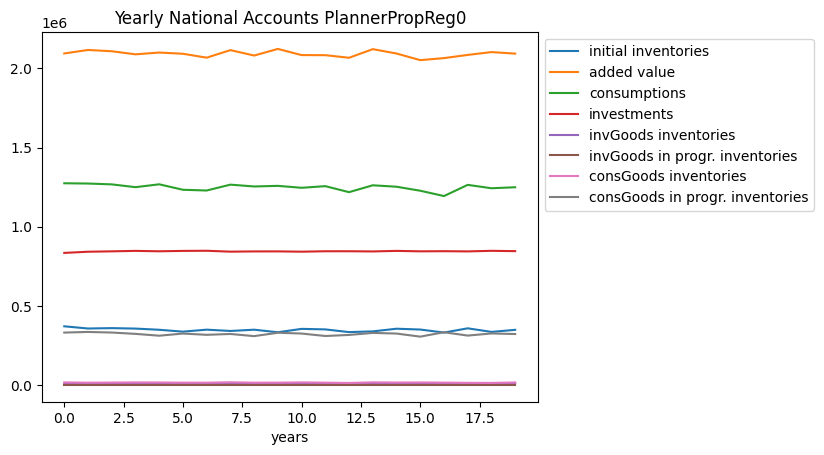

In [14]:
plt.plot(yearlyData,label=['initial inventories', 'added value', 'consumptions',\
             'investments','invGoods inventories', 'invGoods in progr. inventories',\
             'consGoods inventories', 'consGoods in progr. inventories'])
plt.title("Yearly National Accounts "+ folder)
plt.xlabel("years")
#plt.legend(loc='upper right')
plt.legend(bbox_to_anchor=(1, 1))
os.chdir("../"+folder+".0")
plt.savefig("_"+folder+"_YearlyNationalAccounts.jpg", dpi=180, bbox_inches='tight')

In [12]:
with open('../yearlyData/'+folder+".npy", 'wb') as f:
    np.save(f,yearlyData[:,[1,2,3]])